Training weights on larger data (monthly) but doing ARIMA on shorter (yearly)

In [1]:
import numpy as np
import json
import pandas as pd

Read the data

In [6]:
with open('../Data/time_seq2.json') as f:
    time_seq2 = json.load(f)
with open('../Data/subject_predictions_list.json') as f:
    subject_predictions_list = json.load(f)
with open('../Data/subject_seq_weighted.json') as f:
    subject_seq_weighted = json.load(f)

In [7]:
from numpy import loadtxt
y_p2 = loadtxt('../Data/y_p2.csv', delimiter=',')

In [23]:
with open('../Data/topTfIdfNorm.json') as f:
    topTfIdfNorm = json.load(f)
with open('../Data/topTfIdf.json') as f:
    topTfIdf = json.load(f)

In [27]:
df_combined = pd.read_csv('../Data/df_combined_date.csv')

Put data in suitable format

In [28]:
df_combined

,Unnamed: 0,abstract,list_categories,main_categories,year,doubleFilteredAbstracts,topic_hits,topics,subfield,date
0,0,This paper studies the impact of a transmitt...,"['cs.IT', 'math.IT']","['cs', 'math']",2018,"['paper-studies', 'impact', 'transmitter', 'mo...","{13: 1, 196: 1, 99: 1, 48: 4, 102: 3, 19: 1, 1...","[13, 196, 99, 48, 102, 19, 184, 23, 139, 176, ...",IT,318
1,1,Deep Reinforcement Learning (DRL) is conside...,"['cs.LG', 'cs.AI']",['cs'],2021,"['deep-reinforcement-learning', 'drl', 'framew...","{132: 3, 23: 1, 58: 1, 9: 1, 119: 1, 152: 1, 8...","[132, 23, 58, 9, 119, 152, 81, 154, 197, 151, ...",LG,359
2,2,Ad and tracking blocking extensions are popu...,['cs.CR'],['cs'],2018,"['tracking', 'blocking', 'popular', 'tools', '...","{129: 2, 59: 3, 142: 1, 102: 1, 58: 1, 60: 1, ...","[129, 59, 142, 102, 58, 60, 6, 25, 136, 105, 4...",CR,326
3,3,"We introduce a simple, geometric model of op...","['cs.SI', 'econ.TH']","['cs', 'econ']",2019,"['model', 'opinion', 'polarization', 'model', ...","{152: 1, 188: 1, 57: 1, 60: 1, 121: 1, 91: 1, ...","[152, 188, 57, 60, 121, 91, 140, 196, 170, 25,...",SI,338
4,4,Computer vision (CV) has achieved great succ...,['cs.CV'],['cs'],2020,"['computer-vision', 'achieved-great', 'success...","{197: 1, 14: 1, 70: 1, 162: 1, 142: 2, 81: 1, ...","[197, 14, 70, 162, 142, 81, 22, 82, 123, 91, 1...",CV,348
...,...,...,...,...,...,...,...,...,...,...
99995,99995,The number partitioning problem is the probl...,"['cs.DS', 'cs.IT', 'math.CO', 'math.IT']","['cs', 'math']",2020,"['number', 'partitioning', 'problem-problem', ...","{91: 1, 8: 2, 101: 1, 144: 1, 88: 2, 152: 1, 5...","[91, 8, 101, 144, 88, 152, 50, 23, 10, 54, 27,...",DS,349
99996,99996,"As life expectancy is mostly increasing, the...",['cs.GR'],['cs'],2020,"['life', 'disorders', 'constantly', 'growing',...","{120: 1, 55: 1, 73: 1, 138: 1, 58: 1, 196: 1, ...","[120, 55, 73, 138, 58, 196, 97, 4, 40, 6, 102,...",GR,351
99997,99997,We study descriptive complexity properties o...,['cs.FL'],['cs'],2017,"['study', 'descriptive', 'complexity', 'proper...","{140: 1, 10: 1, 84: 1, 88: 1, 104: 7, 36: 1, 9...","[140, 10, 84, 88, 104, 36, 94, 125, 174, 38, 4...",FL,305
99998,99998,"We introduce a binary, relaxed gradient, tru...","['quant-ph', 'cs.NA', 'math.DS', 'math.NA', 'm...","['quant-ph', 'cs', 'math']",2021,"['introduce', 'binary', 'optimizing', 'pulse',...","{23: 1, 96: 2, 176: 1, 130: 1, 36: 1, 114: 1, ...","[23, 96, 176, 130, 36, 114, 18, 88, 102, 2, 91...",NaN,358


In [29]:
def string2list(s):
    s = s.replace('[', '')
    s = s.replace(']', '')
    s = s.replace(' ', '')
    s = s.replace("'", '')
    s = s.replace('"', '')
    terms = s.split(',')
    return terms
df_combined['list_categories'] = df_combined.list_categories.apply(string2list)
df_combined['main_categories'] = df_combined.main_categories.apply(string2list)
df_combined['doubleFilteredAbstracts'] = df_combined.doubleFilteredAbstracts.apply(string2list)
def str2json(s):
    d = {}
    s = s.replace('{', '')
    s = s.replace('}', '')
    s = s.replace("'", '')
    s = s.replace('"', '')
    s = s.replace(' ', '')
    l = s.split(',')
    for term in l:
        pair = term.split(':')
        if(len(pair)>1):
            d[int(pair[0])] = int(pair[1])
    return d

In [30]:
def topics2list(s):
    s = s.replace('dict_keys([', '')
    s = s.replace('])','')
    s = s.replace(' ', '')
    s = s.replace("'", '')
    s = s.replace('[', '')
    s = s.replace(']', '')
    l = s.split(',')
    if(l == ['']):
        return []
    l = [int(x) for x in l]
    return l

In [31]:
df_combined['topic_hits'] = df_combined.topic_hits.apply(str2json)

In [32]:
df_combined['topics'] = df_combined.topics.apply(topics2list)
df_combined

,Unnamed: 0,abstract,list_categories,main_categories,year,doubleFilteredAbstracts,topic_hits,topics,subfield,date
0,0,This paper studies the impact of a transmitt...,"[cs.IT, math.IT]","[cs, math]",2018,"[paper-studies, impact, transmitter, molecule,...","{13: 1, 196: 1, 99: 1, 48: 4, 102: 3, 19: 1, 1...","[13, 196, 99, 48, 102, 19, 184, 23, 139, 176, ...",IT,318
1,1,Deep Reinforcement Learning (DRL) is conside...,"[cs.LG, cs.AI]",[cs],2021,"[deep-reinforcement-learning, drl, framework, ...","{132: 3, 23: 1, 58: 1, 9: 1, 119: 1, 152: 1, 8...","[132, 23, 58, 9, 119, 152, 81, 154, 197, 151, ...",LG,359
2,2,Ad and tracking blocking extensions are popu...,[cs.CR],[cs],2018,"[tracking, blocking, popular, tools, improving...","{129: 2, 59: 3, 142: 1, 102: 1, 58: 1, 60: 1, ...","[129, 59, 142, 102, 58, 60, 6, 25, 136, 105, 4...",CR,326
3,3,"We introduce a simple, geometric model of op...","[cs.SI, econ.TH]","[cs, econ]",2019,"[model, opinion, polarization, model, politica...","{152: 1, 188: 1, 57: 1, 60: 1, 121: 1, 91: 1, ...","[152, 188, 57, 60, 121, 91, 140, 196, 170, 25,...",SI,338
4,4,Computer vision (CV) has achieved great succ...,[cs.CV],[cs],2020,"[computer-vision, achieved-great, success, sem...","{197: 1, 14: 1, 70: 1, 162: 1, 142: 2, 81: 1, ...","[197, 14, 70, 162, 142, 81, 22, 82, 123, 91, 1...",CV,348
...,...,...,...,...,...,...,...,...,...,...
99995,99995,The number partitioning problem is the probl...,"[cs.DS, cs.IT, math.CO, math.IT]","[cs, math]",2020,"[number, partitioning, problem-problem, partit...","{91: 1, 8: 2, 101: 1, 144: 1, 88: 2, 152: 1, 5...","[91, 8, 101, 144, 88, 152, 50, 23, 10, 54, 27,...",DS,349
99996,99996,"As life expectancy is mostly increasing, the...",[cs.GR],[cs],2020,"[life, disorders, constantly, growing, improvi...","{120: 1, 55: 1, 73: 1, 138: 1, 58: 1, 196: 1, ...","[120, 55, 73, 138, 58, 196, 97, 4, 40, 6, 102,...",GR,351
99997,99997,We study descriptive complexity properties o...,[cs.FL],[cs],2017,"[study, descriptive, complexity, properties, l...","{140: 1, 10: 1, 84: 1, 88: 1, 104: 7, 36: 1, 9...","[140, 10, 84, 88, 104, 36, 94, 125, 174, 38, 4...",FL,305
99998,99998,"We introduce a binary, relaxed gradient, tru...","[quant-ph, cs.NA, math.DS, math.NA, math.OC]","[quant-ph, cs, math]",2021,"[introduce, binary, optimizing, pulse, sequenc...","{23: 1, 96: 2, 176: 1, 130: 1, 36: 1, 114: 1, ...","[23, 96, 176, 130, 36, 114, 18, 88, 102, 2, 91...",NaN,358


In [33]:
# Convert monthy time scale to quarterly
def month2quarter(date):
    return int(date/3)

In [34]:
df_combined['date'] = df_combined.date.apply(month2quarter)

In [38]:
minDate = 23900 # Aug 1991
#13 y 4 mo -> 56 quarters to cut off

Calculating hits per quarter

In [24]:
from collections import Counter

In [35]:
hits_per_quarter_hits = {}
for index, row in df_combined.iterrows():
    if(row['date'] in hits_per_quarter_hits.keys()):
        hits_per_quarter_hits[row['date']] = Counter(hits_per_quarter_hits[row['date']]) + Counter(row['topic_hits'])
    else:
        hits_per_quarter_hits[row['date']] = Counter(row['topic_hits'])
for key in hits_per_quarter_hits.keys():
    hits_per_quarter_hits[key] = {k: v for k, v in sorted(dict(hits_per_quarter_hits[key]).items(), key=lambda item: item[1], reverse=True)}

hits_per_quarter_hits = {k: v for k, v in sorted(hits_per_quarter_hits.items(), key=lambda item: item[0], reverse=True)}
hits_per_quarter_hits

{120: {152: 4412,
  142: 4236,
  81: 4072,
  140: 3957,
  23: 3898,
  196: 3783,
  169: 3579,
  91: 3558,
  58: 3301,
  102: 3298,
  97: 3116,
  36: 2852,
  14: 2744,
  111: 2609,
  128: 2411,
  25: 2395,
  78: 2318,
  156: 2104,
  88: 1942,
  136: 1928,
  2: 1907,
  18: 1749,
  176: 1688,
  31: 1630,
  162: 1616,
  141: 1602,
  123: 1496,
  174: 1463,
  90: 1454,
  54: 1445,
  72: 1386,
  68: 1374,
  168: 1367,
  166: 1241,
  46: 1178,
  197: 1102,
  138: 1087,
  16: 1059,
  189: 1048,
  96: 1030,
  8: 1021,
  107: 1015,
  15: 1006,
  85: 1001,
  151: 980,
  120: 971,
  30: 971,
  84: 967,
  114: 958,
  9: 945,
  173: 922,
  41: 917,
  51: 916,
  180: 916,
  170: 913,
  103: 902,
  133: 889,
  60: 832,
  29: 831,
  179: 822,
  86: 810,
  148: 808,
  98: 803,
  40: 791,
  13: 784,
  94: 784,
  22: 768,
  32: 765,
  19: 756,
  7: 745,
  198: 727,
  33: 710,
  165: 704,
  191: 695,
  124: 695,
  48: 695,
  131: 693,
  100: 685,
  45: 685,
  10: 675,
  12: 673,
  74: 672,
  154: 672,
  47

Cut off everything before 2005

In [40]:
#13 y 5 mo -> 57 quarters to cut off, currently quarters 0->120
# Cut off topics which appear less than 6 times
def cutOff(hits_per_year):
    hits_new = {}
    for year in hits_per_year.keys():
        if(year >= 58):
            hits_new[year] = {}
            for topic in hits_per_year[year]:
                if hits_per_year[year][topic] > 6:
                    hits_new[year][topic] = hits_per_year[year][topic]
    return hits_new

In [41]:
hits_quarter = cutOff(hits_per_quarter_hits)

In [44]:
#Find abstracts per quarter
abstracts_per_quarter = {}
for index, row in df_combined.iterrows():
    if(row['date'] in abstracts_per_quarter.keys()):
        abstracts_per_quarter[row['date']] += 1
    else:
        abstracts_per_quarter[row['date']] = 1

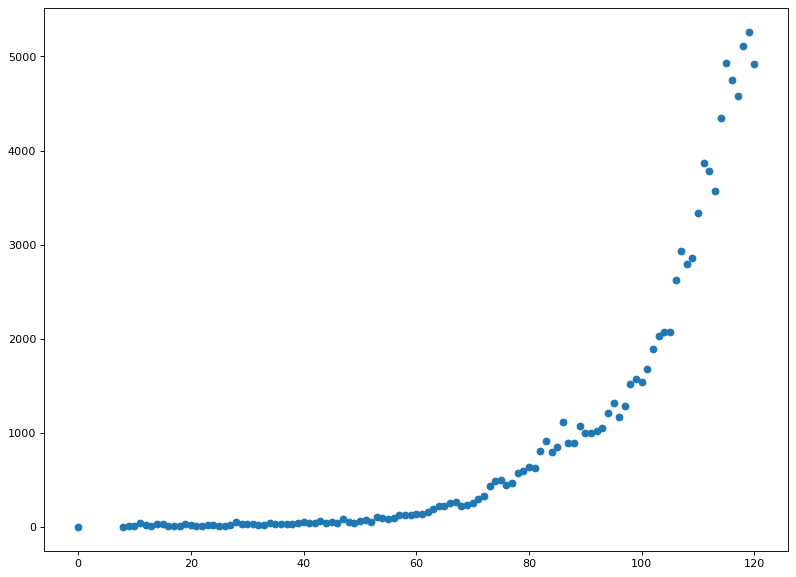

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9), dpi=80)
plt.scatter(list(abstracts_per_quarter.keys()), list(abstracts_per_quarter.values()))

In [43]:
# Normalization
def normalize(hits_per_year, abstracts_per_year):
    hits_normalized = {}
    for year in hits_per_year.keys():
        total = abstracts_per_year[year]
        hits_normalized[int(year)] = {}
        for key in hits_per_year[year].keys():
            hits_normalized[int(year)][key] = hits_per_year[year][key]/total
    return hits_normalized

In [45]:
hits_normalized = normalize(hits_quarter, abstracts_per_quarter)

In [60]:
#Plotting
# 2021: {26: 2100}
# x axis: 2021, y axis: 2100, line: 26
def plottingParams(hits_per_year):
    k = 200 #number of topics
    min_yr = int(min(set(hits_per_year.keys())))
    max_yr = int(max(set(hits_per_year.keys())))
    yrs = max_yr-min_yr+1
    list_years = list(hits_per_year.keys())
    list_years.reverse()
    x_plotting = np.array(list(range(min_yr, max_yr+1)))
    y_plotting = np.zeros((k,yrs))
    for year in hits_per_year.keys():
        for line in hits_per_year[year].keys():
            y_plotting[line][int(year)-min_yr] = hits_per_year[year][line]
    return x_plotting, y_plotting

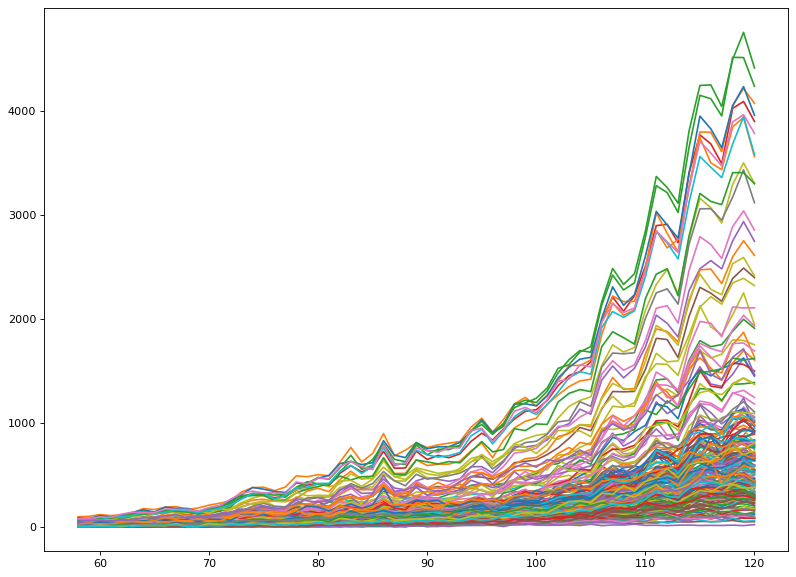

In [83]:
x_plotting, y_plotting = plottingParams(hits_quarter)
k = 200 #number of topics
plt.figure(figsize=(12, 9), dpi=80)
for i in range(k):
    plt.plot(x_plotting, y_plotting[i], label=i)

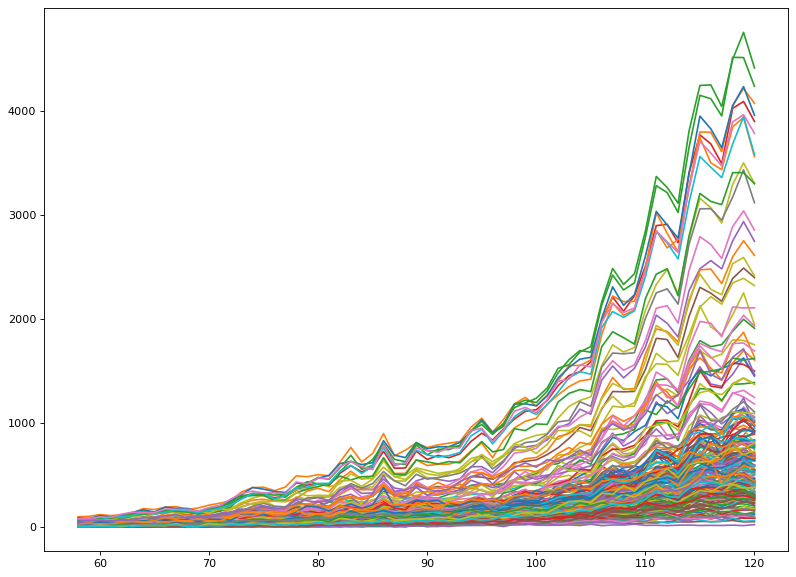

In [84]:
x_p, y_p = plottingParams(hits_normalized)
k = 200 #number of topics
plt.figure(figsize=(12, 9), dpi=80)
for i in range(k):
    plt.plot(x_plotting, y_plotting[i], label=i)

In [102]:
#Making time sequence for subjects
def makeTimeSeq(year_per_subject):
    time_seq = {}
    year_min = int(list(subject_per_year.keys())[-1])
    year_max = int(list(subject_per_year.keys())[0])
    for subj in year_per_subject.keys():
        arr = np.zeros(year_max-year_min+1)
        for year in year_per_subject[subj].keys():
            arr[year-year_min] = year_per_subject[subj][year]
        time_seq[subj] = arr
    return time_seq

In [105]:
# Topic hits per year
# In this and that year I have this many IT, this many LG ...
def yearHits():
    hits_per_year = {}
    for index, row in df_combined.iterrows():
        if(row['date'] in hits_per_year.keys()):
            if(row['subfield'] in hits_per_year[row['date']].keys()):
                hits_per_year[row['date']][row['subfield']] += 1
            else:
                hits_per_year[row['date']][row['subfield']] = 1
        else:
            hits_per_year[row['date']] = {row['subfield'] : 1}
    for key in hits_per_year.keys():
        hits_per_year[key] = {k: v for k, v in sorted(dict(hits_per_year[key]).items(), key=lambda item: item[1], reverse=True)}

    hits_normalized = {}
    for year in hits_per_year.keys():
        total = 0
        hits_normalized[int(year)] = {}
        for key in hits_per_year[year].keys():
            total += hits_per_year[year][key]
        for key in hits_per_year[year].keys():
            hits_normalized[int(year)][key] = hits_per_year[year][key]/total
    
    hits_per_year = {k: v for k, v in sorted(dict(hits_per_year).items(), key=lambda item: item[0], reverse=True)}
    hits_normalized = {k: v for k, v in sorted(dict(hits_normalized).items(), key=lambda item: item[0], reverse=True)}

    return hits_per_year, hits_normalized

In [106]:
subject_per_year, subject_per_year_norm = yearHits()

In [107]:
# Convert dictionary
def year_to_subject(subject_per_year):
    year_per_subject = {}
    for year in subject_per_year.keys():
        d = subject_per_year[year]
        for subj in d.keys():
            if(subj in year_per_subject.keys()):
                year_per_subject[subj][year] = d[subj]
            else:
                year_per_subject[subj] = {year : d[subj]}
    return year_per_subject

In [108]:
year_per_subject_norm = year_to_subject(subject_per_year_norm)

In [109]:
time_seq = makeTimeSeq(year_per_subject_norm)

In [110]:
# Shorten time_seq to post 2005
def shortenTimeSeq(time_seq, y_p):
    ts2 = {}
    startingIndex = len(time_seq['AI'])-len(y_p[0])
    for subj in time_seq.keys():
        ts2[subj] = time_seq[subj][startingIndex:]
    return ts2

In [111]:
time_seq = shortenTimeSeq(time_seq, y_p)

In [113]:
len(time_seq['LG'])

63

In [120]:
def topTfIdfKeysToInt(topTfIdf):
    topTfIdfNew = {}
    for subj in topTfIdf.keys():
        topTfIdfNew[subj] = {}
        for topic in topTfIdf[subj].keys():
            topTfIdfNew[subj][int(topic)] = topTfIdf[subj][topic]
    return topTfIdfNew

In [121]:
topTfIdf = topTfIdfKeysToInt(topTfIdf)
topTfIdfNorm = topTfIdfKeysToInt(topTfIdfNorm)

Ridge Regression

In [177]:
import matplotlib.pyplot as plt

In [189]:
from matplotlib import pyplot 
def plotComparison(sequence, prediction):
    size = int(len(sequence)-len(prediction))
    test = sequence[size:len(sequence)]
    pyplot.figure(figsize=(12, 9), dpi=80)
    pyplot.grid()
    pyplot.plot(test, label='Data')
    pyplot.plot(prediction, color='red', label='Predictions')
    pyplot.legend()

In [378]:
var = list(time_seq.keys())[0]

In [158]:
# Pre-process data to put it in suitable format
def formMatrices(y_p2, time_seq2, topTfIdf):
    learningSubjects = {}
    for subj in topTfIdf.keys():
        learningSubjects[subj] = {}
        if(subj == ''):
            learningSubjects['']['y'] = time_seq2[var]
        elif(subj == "NA"):
            learningSubjects[subj]['y'] = np.zeros(len(time_seq2['LG']))
        else:
            learningSubjects[subj]['y'] = time_seq2[subj]
        learningSubjects[subj]['X'] = np.zeros((len(y_p2[0]), len(topTfIdf[subj].keys())))
        i = 0
        for topic in topTfIdf[subj].keys():
            learningSubjects[subj]['X'][:,i] = y_p2[topic]
            i+=1
    return learningSubjects

In [405]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, Ridge
import math
from sklearn.metrics import mean_squared_error

def weightsPrediction(learningSubjects):
    #Forcasting
    fitted_weights = {}
    for subj in learningSubjects.keys():
        X = learningSubjects[subj]['X']
        y = learningSubjects[subj]['y']
        # Split data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)  
        
        reg = Ridge().fit(X_train, y_train)
        fitted_weights[subj] = reg.coef_
        y_train_pred = reg.predict(X_train)
        y_train_accuracy = math.sqrt(mean_squared_error(y_train, y_train_pred))
        print(y_train_accuracy)
        if(subj == 'LG'):
            plotComparison(y_train, y_train_pred)

        y_test_pred = reg.predict(X_test)
        if(subj == 'LG'):
            plotComparison(y_test, y_test_pred)
        y_test_accuracy = math.sqrt(mean_squared_error(y_test, y_test_pred))
        print(y_test_accuracy)

    return fitted_weights

0.047640342138518386
0.03442123606091941
0.020235142992519075
0.030276871803825153
0.008986549120619207
0.007223534270039166
0.011177097941221136
0.011690675662074587
0.022569010665807434
0.025444376695034493
0.04211671374207147
0.04880166778561662
0.014022052119292886
0.012731286874714951
0.013966281436900027
0.020260377331914547
0.011047385234947318
0.009760311864929235
0.0068200789757558115
0.009612426439287279
0.014377771972023107
0.009809466088992719
0.015917042041283396
0.015059689913518245
0.00937299707467098
0.006308200426001622
0.014726083172540006
0.00854692970536172
0.014256499839384536
0.00808546126117835
0.006329110552751498
0.009715106723055216
0.007269984914931048
0.005064158406746388
0.006770364201550385
0.006894727133948667
0.012651135780658131
0.017580712220327553
0.0071696494208305815
0.005349752813239633
0.002481496599215705
0.0024400539393903144
0.003465152247246423
0.0019819227932991687
0.0023587083309028747
0.0031013865934031303
0.016283008866488643
0.00751840913

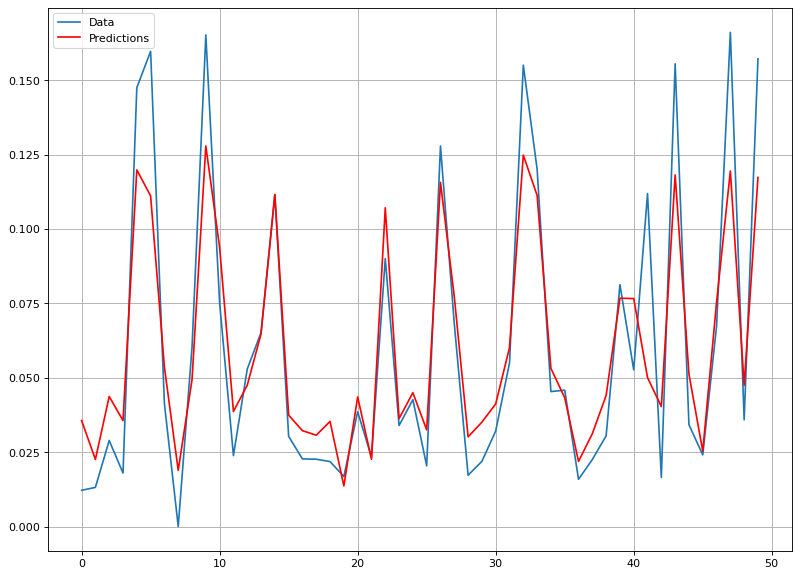

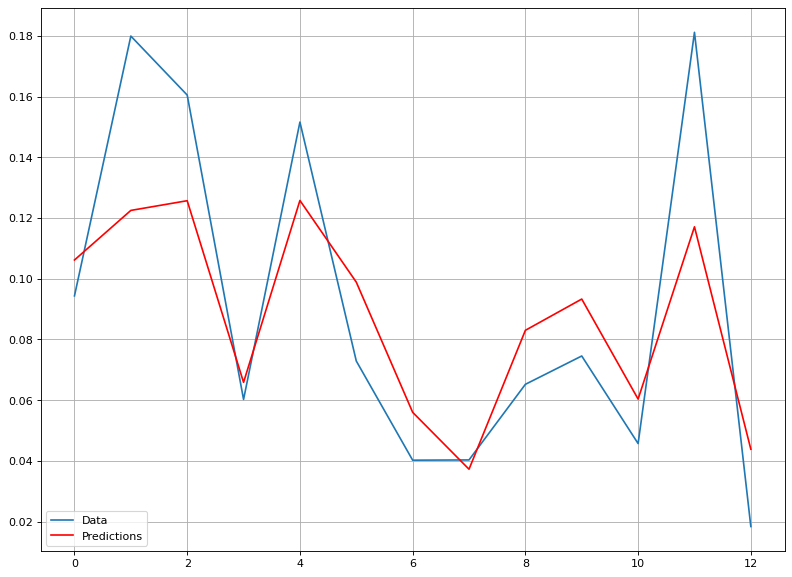

In [407]:
learningSubjects = formMatrices(y_p, time_seq, topTfIdf)
fitted_weights = weightsPrediction(learningSubjects)

Time Series Analysis

In [ ]:
# Seasonality, trends...

In [195]:
import pmdarima as pm
from pmdarima import auto_arima

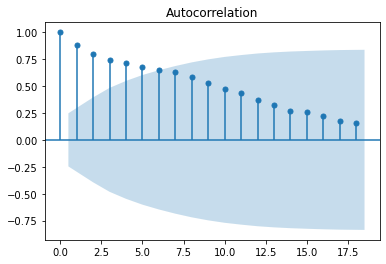

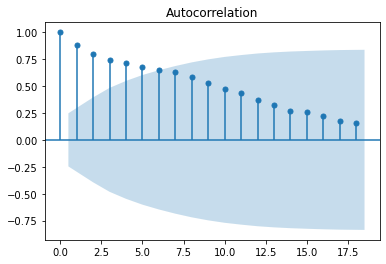

In [85]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y_p[152])

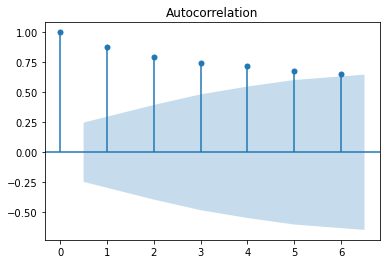

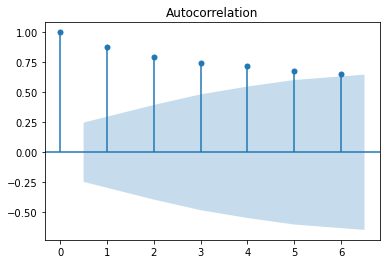

In [86]:
plot_acf(y_p[152], lags = 6)

In [82]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [91]:
pd_topics = pd.DataFrame(y_p.T, index = x_p, columns = range(200))

In [94]:
pd_topics_transposed = pd_topics.T

In [92]:
pd_topics

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
58,0.000000,0.000000,0.226891,0.176471,0.000000,0.000000,0.000000,0.092437,0.285714,0.084034,...,0.109244,0.193277,0.067227,0.000000,0.000000,0.000000,0.621849,0.100840,0.000000,0.000000
59,0.000000,0.000000,0.274194,0.064516,0.096774,0.000000,0.000000,0.000000,0.225806,0.112903,...,0.112903,0.266129,0.000000,0.000000,0.000000,0.000000,0.596774,0.064516,0.000000,0.000000
60,0.000000,0.000000,0.219697,0.128788,0.136364,0.000000,0.000000,0.113636,0.303030,0.060606,...,0.068182,0.159091,0.000000,0.000000,0.000000,0.000000,0.689394,0.098485,0.090909,0.000000
61,0.000000,0.000000,0.270073,0.000000,0.153285,0.000000,0.051095,0.087591,0.211679,0.109489,...,0.000000,0.167883,0.080292,0.000000,0.000000,0.000000,0.642336,0.072993,0.000000,0.000000
62,0.000000,0.000000,0.236842,0.092105,0.098684,0.000000,0.000000,0.065789,0.236842,0.085526,...,0.065789,0.269737,0.131579,0.000000,0.000000,0.000000,0.782895,0.059211,0.000000,0.059211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.021066,0.053718,0.364441,0.129345,0.126185,0.124921,0.075205,0.143038,0.198862,0.164314,...,0.119023,0.167896,0.056667,0.066147,0.002317,0.041500,0.756899,0.214241,0.131873,0.090162
117,0.026218,0.057898,0.382565,0.132838,0.119292,0.111645,0.076251,0.146384,0.193795,0.178938,...,0.123880,0.165829,0.061394,0.069478,0.002185,0.037142,0.757920,0.221324,0.154905,0.088049
118,0.023083,0.062989,0.367567,0.132238,0.139671,0.111307,0.064358,0.144953,0.191706,0.185837,...,0.117762,0.156690,0.061228,0.056534,0.002543,0.039124,0.761346,0.220657,0.148670,0.089789
119,0.019783,0.056306,0.379304,0.133346,0.129351,0.120030,0.091307,0.153510,0.209055,0.174624,...,0.128590,0.151988,0.066388,0.056306,0.001712,0.044893,0.753852,0.228457,0.132014,0.081605


In [98]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(pd_topics[72], autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -0.664034173391244
2. P-Value :  0.8558468902503616
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 52
5. Critical Values :
	 1% :  -3.562878534649522
	 5% :  -2.918973284023669
	 10% :  -2.597393446745562


Auto-ARIMA

In [197]:
from math import sqrt

In [341]:
def autoArima(series, y2y, time_period):
    #Forcasting
    X = series
    size = int(len(X) - time_period)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    # walk-forward validation
    try:
        if(y2y):
            for t in range(len(test)):
                model = auto_arima(history, error_action='ignore', seasonal=True, m=4)
                output = model.predict()
                yhat = output[0]
                predictions.append(yhat)
                obs = test[t]
                history.append(obs)
        else:
            model = auto_arima(history, error_action='ignore', seasonal=True, m=4)
            output = model.predict(n_periods=len(test))
            predictions = output
    except:
        print('Failed')
        return np.zeros(time_period)
    # evaluate forecasts
    rmse = sqrt(mean_squared_error(test, predictions))
    
    return predictions, rmse

In [ ]:
# Auto ARIMA on subjects

In [202]:
subject_predictions_list_auto = {}
rmse_original_auto = {}

for subj in time_seq.keys():
    print(subj)
    subject_predictions_list_auto[subj], rmse_original_auto[subj] = autoArima(time_seq[subj], True, 24)

nan
LG
CV
CL
RO
CR
IT
AI
HC
DC
SE
IR
NI
CY
SI
SD
DS
LO
GT
NE
PL
DB
CE
AR
CC
DL
CG
MM
ET
FL
GR
DM
MS
MA
OH
PF
SY
SC
OS
GL


In [ ]:
# Auto ARIMA on topics

In [225]:
autoArima(y_p[152], True, 24)

([0.7616118252913423,
  0.7682281465487631,
  0.7650083587035683,
  0.7717900181921437,
  0.786903087881744,
  0.7856191495698207,
  0.7943777020638938,
  0.7848772844811491,
  0.8102781398432033,
  0.8155075891384614,
  0.8161299088222688,
  0.829766119534653,
  0.8256494704897468,
  0.8420327786225517,
  0.8410987515632963,
  0.8550223981181772,
  0.8542412783012387,
  0.8660286795566792,
  0.8689183356687005,
  0.8663854026441892,
  0.8851274432229626,
  0.882966978518935,
  0.8869111143650121,
  0.9001940163423994],
 0.018351730885369934)

In [232]:
def doTopicPredictions(y_p, y2y, time_period, auto):
    #Form an arima seqence for the topics
    topic_predictions = np.zeros((len(y_p),time_period))
    for topic in range(len(y_p)):
        print(topic)
        try:
            topic_predictions[topic], r = autoArima(y_p[topic], y2y, time_period)
        except:
            topic_predictions[topic] = np.zeros(time_period)
            print(topic)
    return topic_predictions

In [233]:
topic_predictions = doTopicPredictions(y_p, True, 24, True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


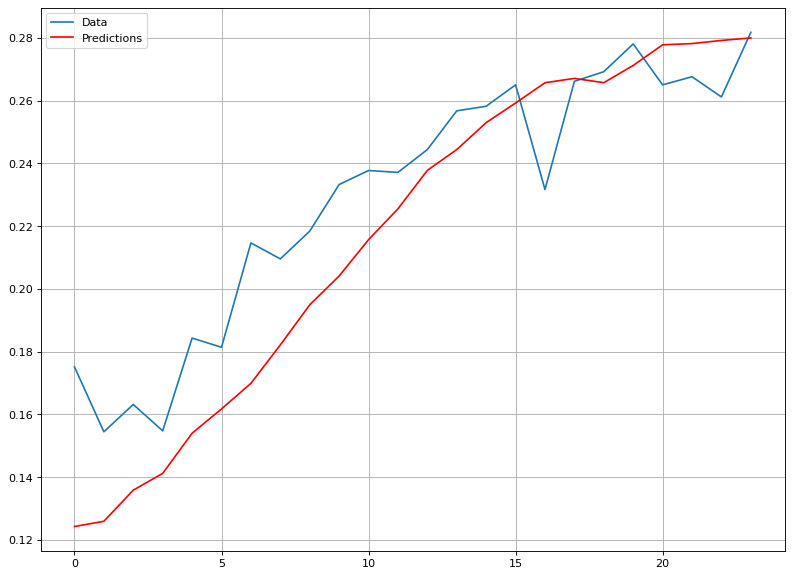

In [368]:
plotComparison(y_p[72], topic_predictions[72])

In [249]:
from numpy import savetxt
savetxt('../Data/topic_predictions_auto.csv', topic_predictions, delimiter=',')

In [254]:
with open('../Data/subject_predictions_list_auto.json', 'w') as f:
    json.dump(subject_predictions_list_auto, f)

In [373]:
def predict(y_p, time_seq, topic_predictions, weights_dict, time_period):

    #Form subject predictions
    subject_seq = {}
    for subject in topTfIdf.keys():
        subject_seq[subject] = np.zeros(time_period)
        for topic in topTfIdf[subject].keys():
            subject_seq[subject] += np.array(topic_predictions[topic])*weights_dict[subject][topic]   
            
    rmse = {}
    index = len(time_seq['AI'])-time_period+1
    for subj in subject_seq.keys():
        if(subj == ''):
            rmse[subj] = sqrt(mean_squared_error(time_seq[var][index:], subject_seq[subj][1:]))
        elif(subj == 'NA'):
            rmse[subj] = 0
        else:
            rmse[subj] = sqrt(mean_squared_error(time_seq[subj][index:], subject_seq[subj][1:]))

    return subject_seq, rmse

In [241]:
len(time_seq['AI'])

63

In [206]:
def formFittedWeightsDict(fitted_weights, topTfIdf):
    weights_dict = {}
    for subj in topTfIdf.keys():
        i = 0
        weights_dict[subj] = {}
        for topic in topTfIdf[subj].keys():
            weights_dict[subj][topic] = fitted_weights[subj][i]
            i += 1
    return weights_dict

In [207]:
weights_dict = formFittedWeightsDict(fitted_weights, topTfIdf)

In [374]:
subject_seq_weighted, rmse_weighted = predict(y_p, time_seq, topic_predictions, weights_dict, 24)

In [376]:
def compareRMSE(rmse1, rmse2):
    rmse_comparison = {}
    for subj in rmse1.keys():
        rmse_comparison[subj] = rmse2[subj]-rmse1[subj]
    return rmse_comparison

In [ ]:
rmse_original_auto[''] = rmse_original_auto[var]
del rmse_original_auto[var]

In [380]:
rmse_weighted

{'IT': 0.04298521169187463,
 'LG': 0.04880648897272429,
 'CR': 0.03253285264207553,
 'SI': 0.0079159716591532,
 'CV': 0.03236538161775442,
 '': 0.17363080383909177,
 'SY': 0.01655441343039458,
 'DS': 0.006799771512862031,
 'DM': 0.0035977135168346595,
 'CY': 0.013137705922205055,
 'CL': 0.01660027780054462,
 'NI': 0.02389810420013948,
 'SE': 0.018805505533401063,
 'CC': 0.008974496316767305,
 'RO': 0.013600818155761255,
 'CG': 0.003831139647138587,
 'HC': 0.012909010818172442,
 'PL': 0.004375320753221278,
 'LO': 0.009641794264769882,
 'NE': 0.014123950021947617,
 'MS': 0.0024253119337778522,
 'MM': 0.005202193220979113,
 'SD': 0.00283067983694474,
 'OH': 0.018723955778492864,
 'IR': 0.0111147764454968,
 'ET': 0.0027548824024985195,
 'DC': 0.01690675770428703,
 'AI': 0.026470338569841885,
 'CE': 0.008809247604047925,
 'DB': 0.010655058102787475,
 'AR': 0.0031286983118787395,
 'GT': 0.008602795196829889,
 'GR': 0.004469906295170607,
 'DL': 0.007874088053278033,
 'MA': 0.00546610582900217

In [400]:
topTfIdfNorm['AI']

{180: 0.2003964681293167,
 131: 0.1859530331928328,
 45: 0.1849383170764444,
 100: 0.1736560124897528,
 14: 0.04891863418256254,
 78: 0.04847459513137595,
 18: 0.045785769932682435,
 88: 0.0400278785070426,
 31: 0.03879058168836777,
 2: 0.03305870966962182}

In [ ]:
test = 0
test2 = 0
for topic in topTfIdf['AI'].keys():
    print(topic_predictions[topic], weights_dict['AI'][topic])
    test += np.array(topic_predictions[topic])*weights_dict['AI'][topic]   
    test2 += np.array(y_p[topic][len(y_p[topic])])*weights_dict['AI'][topic]   

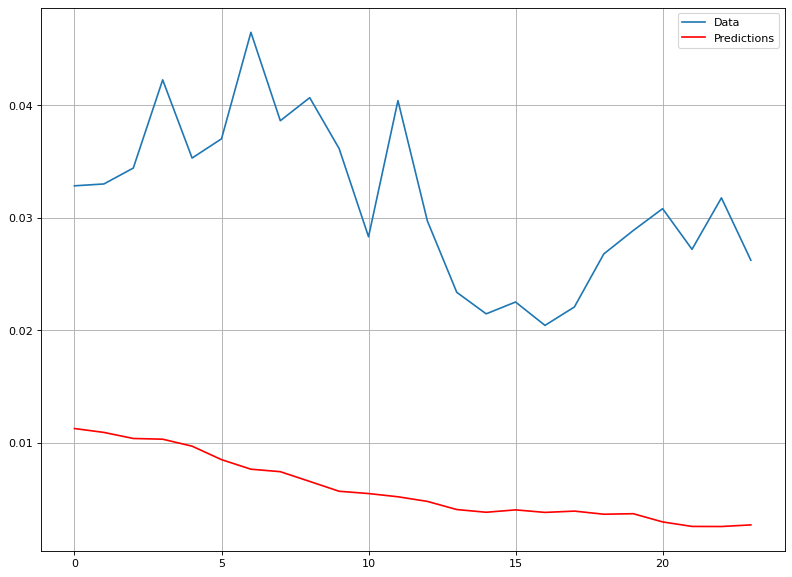

In [398]:
plotComparison(time_seq['AI'], subject_seq_weighted['AI'])

In [399]:
weights_dict['AI']

{180: 0.027642720649189354,
 131: 0.0012364460543021264,
 45: 0.0025552031533571428,
 100: 0.004992014943122928,
 14: -0.0033824294083297088,
 78: -0.014645895621204186,
 18: -0.00396004842948589,
 88: 0.01696986181749392,
 31: 0.00837665636748078,
 2: -0.007428972781671369}

In [263]:
rmse_comp = compareRMSE(rmse_original_auto, rmse_weighted)
rmse_comp

{'LG': 0.03248139089009764,
 'CV': 0.01471351099619557,
 'CL': 0.002637125982163129,
 'RO': 0.00029190458768432216,
 'CR': 0.027074735520426267,
 'IT': 0.032920678566042236,
 'AI': 0.014994841987650798,
 'HC': 0.009697150333586646,
 'DC': 0.009807002917975684,
 'SE': 0.012691293690677188,
 'IR': 0.0072016742507613795,
 'NI': 0.015104874736689481,
 'CY': 0.007405170002325818,
 'SI': 0.0023484010245862124,
 'SD': -0.000389773168381167,
 'DS': -0.004812913931675606,
 'LO': 0.004677741315047344,
 'GT': 0.0041602560112629534,
 'NE': 0.011281661889369809,
 'PL': 0.0011676119315400975,
 'DB': 0.003519979873121949,
 'CE': 0.005899100986890829,
 'AR': -0.0016256325146430778,
 'CC': 0.006018110818070805,
 'DL': 0.005117770668942246,
 'CG': 0.0012401155182191832,
 'MM': 0.0029967981194306374,
 'ET': 0.0008616707985015591,
 'FL': 0.00014313897340008852,
 'GR': 0.0030168578851153777,
 'DM': 0.0018977668881937806,
 'MS': 0.0008612956913024534,
 'MA': 0.0031841565354692974,
 'OH': 0.01548821616914826

Multivariate ARIMA

In [ ]:
pd_topics.corr()
np.all(np.linalg.eigvals(pd_topics.corr()) > 0)

In [278]:
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR

In [332]:
def var_func(pd_topics, cols):
    X = pd_topics
    size = int(len(X)*0.63)
    train, test = X[0:size][:], X[size:len(X)][:]
    mod = VAR(endog=X)
    model_fit = mod.fit()
    prediction = model_fit.forecast(model_fit.y, steps=len(test))
    pred = pd.DataFrame(index=range(0,len(prediction)),columns=cols)
    for j in cols:
        for i in range(0, len(prediction)):
            pred.iloc[i][j] = prediction[i][j]

    return prediction, pred

In [333]:
var_pred, pred_df = var_func(pd_topics, cols=range(200))

/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/miamijovic/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [334]:
pred_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.025107,0.061612,0.397669,0.133545,0.130804,0.126377,0.087761,0.156709,0.181827,0.188753,...,0.125122,0.152664,0.06406,0.059419,0.002386,0.039741,0.776288,0.234217,0.15178,0.086921
1,0.027333,0.062236,0.400957,0.126865,0.132,0.134572,0.08039,0.156432,0.185942,0.191844,...,0.123776,0.149968,0.065596,0.052683,0.006217,0.043122,0.777701,0.233007,0.146875,0.087772
2,0.027542,0.065164,0.404836,0.135173,0.135744,0.127485,0.084867,0.156498,0.191517,0.181278,...,0.131323,0.147759,0.079111,0.056436,0.005639,0.045557,0.780938,0.240263,0.144504,0.090323
3,0.024576,0.069769,0.401981,0.132082,0.126521,0.142032,0.081882,0.159355,0.195477,0.182712,...,0.123982,0.142161,0.059881,0.049869,0.006922,0.046941,0.782053,0.242127,0.148156,0.091407
4,0.024695,0.070475,0.401142,0.144158,0.125265,0.134346,0.086767,0.159741,0.204379,0.194225,...,0.121802,0.144402,0.062838,0.061522,0.007673,0.040808,0.78237,0.238495,0.15899,0.090796
5,0.027417,0.068516,0.405942,0.138286,0.128794,0.138448,0.073068,0.160477,0.184363,0.194194,...,0.123141,0.145312,0.054169,0.057164,0.00569,0.040219,0.780171,0.240141,0.160566,0.088938
6,0.026617,0.067327,0.408576,0.142385,0.131672,0.141268,0.079027,0.16263,0.189913,0.194218,...,0.119141,0.136652,0.058092,0.061758,0.004353,0.043621,0.781075,0.238834,0.158373,0.095304
7,0.026702,0.069829,0.417376,0.138181,0.131786,0.149034,0.08166,0.163875,0.180674,0.196,...,0.115145,0.119804,0.046967,0.058941,0.004786,0.045424,0.777288,0.245871,0.161033,0.092665
8,0.024246,0.073604,0.415949,0.141247,0.132841,0.146798,0.091039,0.163595,0.172568,0.198431,...,0.114365,0.124092,0.050413,0.061663,0.005082,0.04778,0.778289,0.24379,0.169829,0.095908
9,0.028332,0.071849,0.421461,0.134209,0.132388,0.152739,0.087249,0.170528,0.165399,0.200571,...,0.115883,0.125068,0.037822,0.057472,0.004295,0.044325,0.776315,0.246239,0.171004,0.092194


In [337]:
topic_predictions_var = var_pred.T

In [338]:
subject_seq_var, rmse_var = predict(y_p, time_seq, topic_predictions_var, weights_dict, 24)

In [340]:
#rmse_comp_var = compareRMSE(rmse_original_auto, rmse_var)
rmse_comp_var = compareRMSE(rmse_weighted, rmse_var)
rmse_comp_var

{'IT': -0.020991230043846107,
 'LG': -0.01787664540989575,
 'CR': 0.0006787989165974867,
 'SI': 0.00032880314887603554,
 'CV': 0.008798415672070847,
 '': -0.01720385997077295,
 'SY': -0.0006086470017696508,
 'DS': 0.006421667087891118,
 'DM': -0.0004523707906670875,
 'CY': -0.00018474436683569954,
 'CL': 0.0050924569278031385,
 'NI': 0.005952373251890894,
 'SE': 0.0006269980652743694,
 'CC': -0.004380349319807777,
 'RO': -0.004195151812349411,
 'CG': 0.0023078973117653437,
 'HC': -0.00039501386211218854,
 'PL': 0.0007204402674528283,
 'LO': 0.008893362954088088,
 'NE': 0.0005803996003903716,
 'MS': 0.0001287665426588343,
 'MM': 0.0007199519869513253,
 'SD': 0.002485007878616643,
 'OH': 0.005968883082990286,
 'IR': -0.0010220445255078314,
 'ET': -0.00017371366576085382,
 'DC': 0.0008367654654008461,
 'AI': 0.006820835342031296,
 'CE': 0.001153619999375341,
 'DB': 0.0035771828592257235,
 'AR': 0.0021043471380696537,
 'GT': 0.0026022032366489894,
 'GR': -1.2001067261321711e-05,
 'DL': 0.0

Long time predictions

In [342]:
subject_predictions_list_long = {}
rmse_original_long = {}

for subj in time_seq.keys():
    print(subj)
    subject_predictions_list_long[subj], rmse_original_long[subj] = autoArima(time_seq[subj], False, 24)

nan
LG
CV
CL
RO
CR
IT
AI
HC
DC
SE
IR
NI
CY
SI
SD
DS
LO
GT
NE
PL
DB
CE
AR
CC
DL
CG
MM
ET
FL
GR
DM
MS
MA
OH
PF
SY
SC
OS
GL


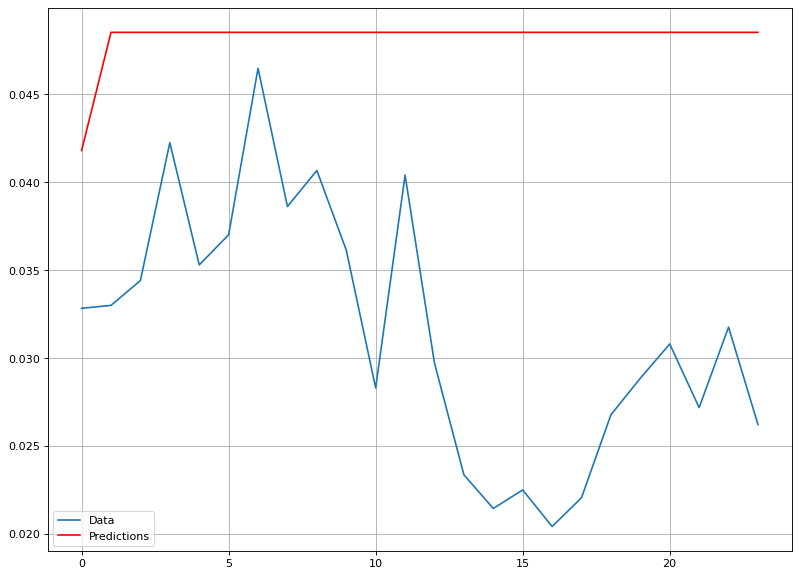

In [361]:
plotComparison(time_seq['AI'],subject_predictions_list_long['AI'])

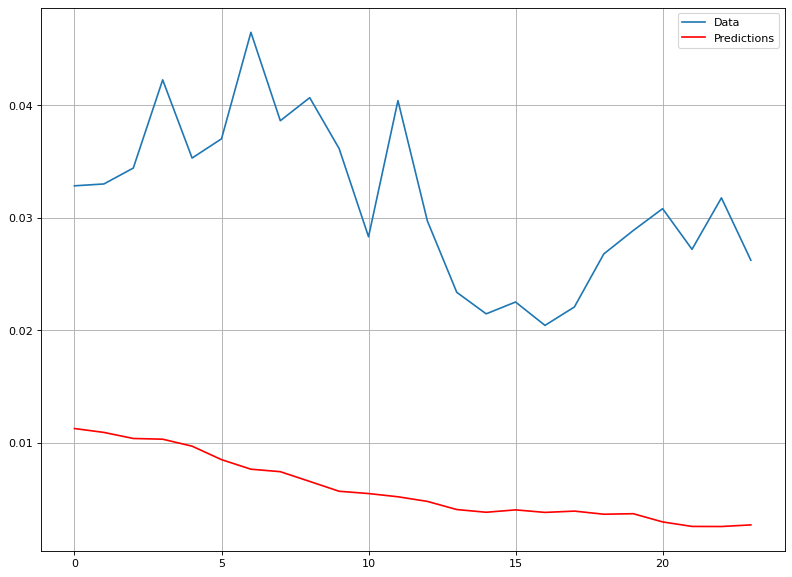

In [362]:
plotComparison(time_seq['AI'],subject_seq_weighted['AI'])

In [344]:
rmse_original_long[''] = rmse_original_long[var]
del(rmse_original_long[var])

In [346]:
rmse_comp_var = compareRMSE(rmse_original_long, rmse_weighted)
rmse_comp_var

{'LG': -0.015413432430662698,
 'CV': -0.003828562577945706,
 'CL': -0.03595565915680373,
 'RO': -0.009763226631443672,
 'CR': 0.02652011571266858,
 'IT': 0.029965222339423003,
 'AI': 0.008258888060916712,
 'HC': 0.00874947744763865,
 'DC': 0.008910571138092354,
 'SE': 0.010174927881972598,
 'IR': 0.007081671223249238,
 'NI': -0.0037089551759258363,
 'CY': 0.007039190572666803,
 'SI': -0.02701454501501452,
 'SD': -0.004587459398688573,
 'DS': -0.01987518092756761,
 'LO': -0.0006812994593902548,
 'GT': -0.0018052133207405244,
 'NE': 0.010356949063717202,
 'PL': -0.00232598438124125,
 'DB': -0.0008847301260946697,
 'CE': 0.004151434350096041,
 'AR': -0.0026136391599945416,
 'CC': 0.0013349433877303599,
 'DL': 0.002049897149520724,
 'CG': -0.0031516792761444334,
 'MM': 0.0028623116980652915,
 'ET': 0.0006164595517606972,
 'FL': -0.0016736344259104924,
 'GR': 0.003090280411801802,
 'DM': 0.0006732908080662142,
 'MS': 0.0006673963038024506,
 'MA': 0.003380111347871155,
 'OH': 0.0034510661907

Predicting subfield code from the topics

In [444]:
def formTopicMatrix(topic_list, subfield_list, counts):
    i = 0
    topic_matrix = np.zeros((len(subfield_list), 200))
    for i in range(len(subfield_list)):
        if(not counts):
            for topic in topic_list[i]:
                topic_matrix[i][topic] = 1
        else:
            for topic in topic_list[i].keys():
                topic_matrix[i][topic] = topic_list[i][topic]
    return topic_matrix


In [ ]:
for index, row in df_combined.iterrows():
    if(type(row['subfield']) != str):
        df_combined.at[index, 'subfield'] = ''

In [445]:
topics_matrix = formTopicMatrix(list(df_combined['topics']), list(df_combined['subfield']), False)
topic_hits_matrix = formTopicMatrix(list(df_combined['topic_hits']), list(df_combined['subfield']), True)

In [533]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

def predictSubfieldCode(topics_matrix, subfields):
    X = topics_matrix
    y = subfields
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    classifier = MultinomialNB()
    classifier.fit(X_train, y_train)

    # Predict Class
    y_pred = classifier.predict(X_test)

    # Accuracy 
    accuracy = accuracy_score(y_test, y_pred)
    f1s = f1_score(y_test, y_pred, average='macro')  
    print(len(y_test))

    return y_pred, accuracy, f1s, y_test

In [496]:
y_pred, accuracy, f1s, y_test = predictSubfieldCode(topics_matrix, list(df_combined['subfield']))

In [497]:
accuracy, f1s

(0.4845, 0.3326705441622809)

In [498]:
zip_iterator = zip(y_test, y_pred)
checking = dict(zip_iterator)
print(checking)

{'': '', 'CV': 'NI', 'PL': 'LO', 'CL': 'CL', 'DS': 'CC', 'GR': 'CR', 'CR': 'CR', 'LG': 'CV', 'HC': 'CL', 'CG': 'CG', 'MA': 'HC', 'NE': 'NE', 'FL': 'FL', 'ET': '', 'RO': 'RO', 'SD': 'CV', 'SI': '', 'DL': 'CR', 'AI': 'RO', 'MS': 'IT', 'NI': 'NI', 'IT': 'IT', 'LO': 'LO', 'CY': 'CR', 'AR': 'DC', 'CC': 'DS', 'SE': 'SE', 'CE': 'CE', 'DM': 'DS', 'SC': '', 'DC': 'AR', 'DB': '', 'IR': 'IR', 'GT': 'GT', 'SY': 'SY', 'OH': '', 'OS': 'AR', 'PF': 'DC', 'MM': 'NI', 'GL': ''}


In [469]:
subf_counter = Counter(df_combined['subfield'])

In [516]:
def sampleUniform(topics_matrix, subfields, k):
    count = {}
    for subf in set(subfields):
        count[subf] = 0
    new_matrix = np.zeros((len(set(subfields))*k, 200))
    new_subfields = ['']*(len(set(subfields))*k)
    j = 0
    for i in range(len(topics_matrix)):
        if(count[subfields[i]]<k):
            new_matrix[j] = topics_matrix[i]
            new_subfields[j] = subfields[i]
            j += 1
            count[subfields[i]] += 1
    print(count)
    return new_matrix, new_subfields

In [555]:
new_matrix, new_subfields  = sampleUniform(topics_matrix, list(df_combined['subfield']), 200)

{'': 200, 'NI': 200, 'MM': 200, 'LO': 200, 'NE': 200, 'DC': 200, 'CE': 200, 'CL': 200, 'SE': 200, 'RO': 200, 'OH': 200, 'PF': 200, 'DB': 200, 'CC': 200, 'MA': 200, 'CG': 200, 'CV': 200, 'SI': 200, 'IR': 200, 'GL': 22, 'DL': 200, 'SY': 200, 'HC': 200, 'FL': 200, 'SD': 200, 'DM': 200, 'LG': 200, 'DS': 200, 'ET': 200, 'CY': 200, 'SC': 200, 'AI': 200, 'GT': 200, 'OS': 94, 'MS': 200, 'GR': 200, 'CR': 200, 'IT': 200, 'AR': 200, 'PL': 200}


In [558]:
y_pred_new, accuracy, f1s, y_test_new = predictSubfieldCode(new_matrix, new_subfields)

1600


In [559]:
accuracy, f1s

(0.429375, 0.3982270125173731)

In [560]:
len(y_test_new)

1600

In [561]:
zip_iterator2 = zip(y_test_new, y_pred_new)
print(list(zip_iterator2))

[('SI', 'SI'), ('ET', 'IT'), ('IT', 'IT'), ('AR', 'OH'), ('DL', 'CY'), ('DM', 'CG'), ('CL', 'CL'), ('DS', 'DM'), ('MS', 'MS'), ('SC', 'DM'), ('GT', 'MA'), ('RO', 'RO'), ('IT', 'IT'), ('SI', 'DS'), ('', ''), ('OS', 'PL'), ('SY', 'CC'), ('CC', 'IT'), ('DM', 'DM'), ('OS', 'AR'), ('DC', 'MS'), ('OH', 'AR'), ('MS', 'CE'), ('CR', 'NI'), ('NI', 'NI'), ('DS', 'CG'), ('FL', 'CC'), ('SE', 'DL'), ('DM', 'DM'), ('CV', 'SD'), ('FL', 'LO'), ('SY', 'SY'), ('SY', 'IT'), ('DS', 'CG'), ('', 'CV'), ('IT', 'NI'), ('LO', 'LO'), ('RO', 'CV'), ('DC', 'DS'), ('', ''), ('IT', 'IT'), ('CG', 'CR'), ('NE', 'NE'), ('AI', 'MA'), ('LO', 'LO'), ('DM', 'IT'), ('', 'SC'), ('CC', 'DM'), ('FL', 'FL'), ('CL', 'CL'), ('OH', 'DB'), ('AR', 'AR'), ('DB', 'DB'), ('SE', 'OH'), ('DM', 'CC'), ('GR', 'CE'), ('IR', 'SI'), ('GR', 'CC'), ('LG', 'CL'), ('', ''), ('AI', 'OH'), ('SE', 'HC'), ('NI', 'NI'), ('DC', 'MS'), ('CL', 'MM'), ('GT', 'MA'), ('SD', 'IR'), ('AR', 'AR'), ('NI', 'NI'), ('', ''), ('PL', 'LO'), ('ET', 'ET'), ('CY', 'CY'